In [1]:
#Load i-Tesla Data
import numpy as np
import pandas as pd
# X_orig = np.genfromtxt('CaseStudyiTesla\X.csv', delimiter=',')
# Y_orig = np.genfromtxt('CaseStudyiTesla\Y1.csv', delimiter=',')
X_org = pd.read_csv('CaseStudyiTesla\X.csv', index_col =False, header=None)
Y_org = pd.read_csv('CaseStudyiTesla\Y1.csv', index_col =False, header=None)

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.metrics import f1_score
# from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.colors as mcolors


X_ = X_org.dropna(axis=1)
y = Y_org

#time for preprocessing
pre_s = time.time()

#Pre-process data
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_)
X_ = pd.DataFrame(X_minmax)

pre_f = time.time() - pre_s

#define performance variables
results = np.zeros(4); stop = np.zeros(4); start = np.zeros(4); #select = np.zeros(4)
tn = np.zeros(4); tp = np.zeros(4); fn = np.zeros(4); fp = np.zeros(4)
fpr = dict(); tpr = dict(); thresholds = dict(); roc_auc = dict()
tprr = dict(); fprr = dict()
node_count = np.zeros(4)

# contingencies = [0,1,5,8,9] ; # ,10,17,18,19,800,1000
# for j,k in enumerate(contingencies):


lbl = 800
feat_s = time.time()
#Split data into training, CV and test set
X_train, X_test, y_train, y_test = train_test_split(X_,y[lbl],test_size=0.25, random_state = 0)
#Initialize decision tree
clff = DecisionTreeClassifier(random_state=0)

#fit decision tree on all training data and do feature selection
clff.fit(X_train, y_train)
model = SelectFromModel(clff, prefit=True)
X_new = model.transform(X_train)
X_new = pd.DataFrame(X_new)
X_new.columns = X_train.columns[model.get_support()]
#indices = np.argsort(clff.feature_importances_)[::-1]

X_test = pd.DataFrame(X_test)
X_test = X_test[X_train.columns[model.get_support()]]
X_train = X_new
select = X_test.shape[1]
feat_f = time.time() - feat_s

for i in list(range(2,6)):   
    #initiate timer
    start[i-2] = time.time()
    
#     #Split data into training, CV and test set
#     X_train, X_test, y_train, y_test = train_test_split(X_,y[lbl],test_size=0.25, random_state = 0)
    
#     #Initialize decision tree
#     clff = DecisionTreeClassifier(random_state=0)
    
#     #fit decision tree on all training data and do feature selection
#     clff.fit(X_train, y_train)
#     model = SelectFromModel(clff, prefit=True)
#     X_new = model.transform(X_train)
#     X_new = pd.DataFrame(X_new)
#     X_new.columns = X_train.columns[model.get_support()]
#     #indices = np.argsort(clff.feature_importances_)[::-1]

#     X_test = pd.DataFrame(X_test)
#     X_test = X_test[X_train.columns[model.get_support()]]
#     X_train = X_new
#     select[i-2] = X_test.shape[1]
    clff.max_depth = i
    clff.fit(X_train,y_train)
    
    #Calibrate Classifier
    clf_cal = CalibratedClassifierCV(clff,cv=5,method='sigmoid')
    clf_cal.fit(X_train,y_train)
    
    stop[i-2] = time.time()-start[i-2]
    
    #store number of nodes
    node_count[i-2] = clff.tree_.node_count
    
    #predict result and compute preformance 
    y_pred = clff.predict(X_test)
    #y_score = clff.predict_proba(X_test)[:,1]
    y_score = clf_cal.predict_proba(X_test)[:,1]
    results[i-2] = f1_score(y_test, y_pred)
    #dot_data = tree.export_graphviz(clff, out_file=file[i-2])
    fpr[i-2], tpr[i-2], thresholds[i-2] = roc_curve(y_test, y_score)
    #roc_auc[i-2] = auc(fpr[i-2],tpr[i-2])
    
    #New Addition
    N1 = y[lbl].value_counts()[1] #Positive values
    N2 = y[lbl].value_counts()[0] #Negative values
    P1 = (N1/(N1+N2)) #π+
    P2 = (N2/(N1+N2)) #π-
    #Define cost values
    C_fp = 1
    C_fn = 1
    #define Threshold
    z = (P2*C_fp)/((P2*C_fp)+(P1*C_fn))

    #Make prediction
    y_new = np.array([])
    for j in range(y_test.shape[0]):
        if(y_score[j]>=z):
            y_new = np.append(y_new,1)
        else:
            y_new = np.append(y_new,0)
            
    #Find Confusion matrix and ROC co-ordinates        
#     y_new.tolist()

    y_test = np.array(y_test)
    #get confusion matrix
    tn[i-2],fp[i-2],fn[i-2],tp[i-2] = confusion_matrix(y_test, y_new).ravel()
    
    #calculate tprr and fprr
    #default
    tprr[i-2] = tp[i-2]/(tp[i-2]+fn[i-2])
    fprr[i-2] = fp[i-2]/(fp[i-2]+tn[i-2]) 
    

nValues = np.arange(int(node_count[-1]))
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet
#Plot figures
plt.figure()
#plot ROC Curve
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.plot(fpr[0],tpr[0],color=colormap(normalize(int(node_count[0]))),lw=2)
plt.plot(fpr[1],tpr[1],color=colormap(normalize(int(node_count[1]))), lw=2)
plt.plot(fpr[2],tpr[2],color=colormap(normalize(int(node_count[2]))), lw=2)
plt.plot(fpr[3],tpr[3],color=colormap(normalize(int(node_count[3]))), lw=2)
#Plot Ideal Operating points
plt.plot(fprr[0],tprr[0],marker='X',color=colormap(normalize(int(node_count[0]))))
plt.plot(fprr[1],tprr[1],marker='X',color=colormap(normalize(int(node_count[1]))))
plt.plot(fprr[2],tprr[2],marker='X',color=colormap(normalize(int(node_count[2]))))
plt.plot(fprr[3],tprr[3],marker='X',color=colormap(normalize(int(node_count[3]))))

plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic with tree depth')
#plt.legend(loc="lower right")


scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(nValues)
scalarmappable.set_clim(-0.5,int(node_count[-1])+0.5)
plt.colorbar(scalarmappable).set_label("Interpretability \n (Nodes)")
# plt.savefig('plot_name.png', dpi = 500)
plt.show()   



<Figure size 640x480 with 2 Axes>

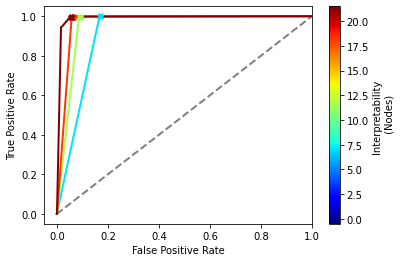

In [90]:
y = Y_org
lbl = 19
feat_s = time.time()
#Split data into training, CV and test set
X_train, X_test, y_train, y_test = train_test_split(X_,y[lbl],test_size=0.25, random_state = 0)
#Initialize decision tree
clff = DecisionTreeClassifier(random_state=0)

#fit decision tree on all training data and do feature selection
clff.fit(X_train, y_train)
model = SelectFromModel(clff, prefit=True)
X_new = model.transform(X_train)
X_new = pd.DataFrame(X_new)
X_new.columns = X_train.columns[model.get_support()]
#indices = np.argsort(clff.feature_importances_)[::-1]

X_test = pd.DataFrame(X_test)
X_test = X_test[X_train.columns[model.get_support()]]
X_train = X_new
select = X_test.shape[1]
feat_f = time.time() - feat_s
for i in list(range(2,6)):   
    #initiate timer
    start[i-2] = time.time()
    
    clff.max_depth = i
    clff.fit(X_train,y_train)
    
    #Calibrate Classifier
    clf_cal = CalibratedClassifierCV(clff,cv=5,method='sigmoid')
    clf_cal.fit(X_train,y_train)
    
    stop[i-2] = time.time()-start[i-2]
    
    #store number of nodes
    node_count[i-2] = clff.tree_.node_count
    
    #predict result and compute preformance 
    y_pred = clff.predict(X_test)
    #y_score = clff.predict_proba(X_test)[:,1]
    y_score = clf_cal.predict_proba(X_test)[:,1]
    results[i-2] = f1_score(y_test, y_pred)
    #dot_data = tree.export_graphviz(clff, out_file=file[i-2])
    fpr[i-2], tpr[i-2], thresholds[i-2] = roc_curve(y_test, y_score)
    #roc_auc[i-2] = auc(fpr[i-2],tpr[i-2])
    
    #New Addition
    N1 = y[lbl].value_counts()[1] #Positive values
    N2 = y[lbl].value_counts()[0] #Negative values
    P1 = (N1/(N1+N2)) #π+
    P2 = (N2/(N1+N2)) #π-
    #Define cost values
    C_fp = 2
    C_fn = 1
    #define Threshold
    z = (P2*C_fp)/((P2*C_fp)+(P1*C_fn))

    #Make prediction
    y_new = np.array([])
    for j in range(y_test.shape[0]):
        if(y_score[j]>=z):
            y_new = np.append(y_new,1)
        else:
            y_new = np.append(y_new,0)
            
    #Find Confusion matrix and ROC co-ordinates        
#     y_new.tolist()

    y_test = np.array(y_test)
    #get confusion matrix
    tn[i-2],fp[i-2],fn[i-2],tp[i-2] = confusion_matrix(y_test, y_new).ravel()
    
    #calculate tprr and fprr
    #default
    tprr[i-2] = tp[i-2]/(tp[i-2]+fn[i-2])
    fprr[i-2] = fp[i-2]/(fp[i-2]+tn[i-2]) 
    

nValues = np.arange(int(node_count[-1]))
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
colormap = cm.jet
#Plot figures
plt.figure()
#plot ROC Curve
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.plot(fpr[0],tpr[0],color=colormap(normalize(int(node_count[0]))),lw=2)
plt.plot(fpr[1],tpr[1],color=colormap(normalize(int(node_count[1]))), lw=2)
plt.plot(fpr[2],tpr[2],color=colormap(normalize(int(node_count[2]))), lw=2)
plt.plot(fpr[3],tpr[3],color=colormap(normalize(int(node_count[3]))), lw=2)
#Plot Ideal Operating points
plt.plot(fprr[0],tprr[0],marker='X',color=colormap(normalize(int(node_count[0]))))
plt.plot(fprr[1],tprr[1],marker='X',color=colormap(normalize(int(node_count[1]))))
plt.plot(fprr[2],tprr[2],marker='X',color=colormap(normalize(int(node_count[2]))))
plt.plot(fprr[3],tprr[3],marker='X',color=colormap(normalize(int(node_count[3]))))

plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic with tree depth')
#plt.legend(loc="lower right")


scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(nValues)
scalarmappable.set_clim(-0.5,int(node_count[-1])+0.5)
plt.colorbar(scalarmappable).set_label("Interpretability \n (Nodes)")
plt.savefig('ROC-17.png', dpi = 700)
plt.show()   


In [91]:
stop

array([1.34240985, 1.33126616, 1.7229147 , 1.95377588])

In [92]:
feat_f

625.9227411746979

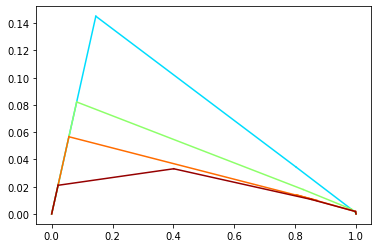

In [95]:
#Cost curves (Combination)
# cc = 1

cc_s = time.time()
for cc in range(len(tpr)):
    size = fpr[cc].shape[0]

    #define cost and tolerance range
    x = 0.5
    x_ = x*1.2
    _x = x*0.8
    #define relative cost
    c = (1-x)/x
    c_ = (1-x_)/x_
    _c = (1-_x)/_x
    p = np.linspace(0,1,size)
    z = (1-p)/((1-p)+ p*c)

    E = ['' for i in range(size)]
    E_ = ['' for i in range(size)]
    _E = ['' for i in range(size)]
    for i in range(size):
        E[i] = ((1-tpr[cc][i])*p*c + fpr[cc][i]*(1-p))/(p*c + (1-p))
        _E[i] = ((1-tpr[cc][i])*p*_c + fpr[cc][i]*(1-p))/(p*_c + (1-p))
        E_[i] = ((1-tpr[cc][i])*p*c_ + fpr[cc][i]*(1-p))/(p*c_ + (1-p))

    if(size >= 6):
#         E = [E[0],E[round(size/8)],E[round(size/4)],E[round(3*size/8)],E[round(size/2)],E[round(5*size/8)],E[round(3*size/4)],E[-1]]
#         _E = [_E[0],_E[round(size/8)],_E[round(size/4)],_E[round(3*size/8)],_E[round(size/2)],_E[round(5*size/8)],_E[round(3*size/4)],_E[-1]]
#         E_ = [E_[0],E_[round(size/8)],E_[round(size/4)],E_[round(3*size/8)],E_[round(size/2)],E_[round(5*size/8)],E_[round(3*size/4)],E_[-1]]

        E = [E[0],E[round(size/4)],E[round(size/2)],E[round(3*size/4)],E[-1]]
        _E = [_E[0],_E[round(size/4)],_E[round(size/2)],_E[round(3*size/4)],_E[-1]]
        E_ = [E_[0],E_[round(size/4)],E_[round(size/2)],E_[round(3*size/4)],E_[-1]]
    else:
        E = [E[0],E[1],E[-2],E[-1]]
        _E = [_E[0],_E[1],_E[-2],_E[-1]]
        E_ = [E_[0],E_[1],E_[-2],E_[-1]]
        
    
    #Plot cost curves
    x = np.zeros(len(E)+1)
    y = np.zeros(len(E)+1)

    for i in range(len(E)-1):
        x[i+1],y[i+1] = intersection(p,E[i],p,E[i+1])
    x[len(E)],y[len(E)] = (1,0)
    for i in range(len(E)):
        plt.plot([x[i],x[i+1]],[y[i],y[i+1]],color=colormap(normalize(int(node_count[cc]))))    

cc_f = time.time() - cc_s
# for i in range(len(E)):
#     plt.plot(p,E[i])    
# plt.ylim(0,1)
plt.savefig('cont19-cc.PNG', dpi=700)

In [96]:
cc_f

0.07579660415649414

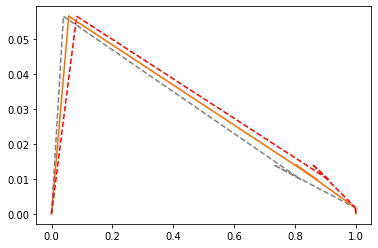

In [98]:
#Cost curves (individual with error tolerance)
cc = 2
size = fpr[cc].shape[0]

#define cost and tolerance range
x = 0.5
x_ = x*1.2
_x = x*0.8
#define relative cost
c = (1-x)/x
c_ = (1-x_)/x_
_c = (1-_x)/_x
p = np.linspace(0,1,size)
z = (1-p)/((1-p)+ p*c)

E = ['' for i in range(size)]
E_ = ['' for i in range(size)]
_E = ['' for i in range(size)]
for i in range(size):
    E[i] = ((1-tpr[cc][i])*p*c + fpr[cc][i]*(1-p))/(p*c + (1-p))
    _E[i] = ((1-tpr[cc][i])*p*_c + fpr[cc][i]*(1-p))/(p*_c + (1-p))
    E_[i] = ((1-tpr[cc][i])*p*c_ + fpr[cc][i]*(1-p))/(p*c_ + (1-p))

if(size >= 6):
    E = [E[0],E[round(size/4)],E[round(size/2)],E[round(3*size/4)],E[-1]]
    _E = [_E[0],_E[round(size/4)],_E[round(size/2)],_E[round(3*size/4)],_E[-1]]
    E_ = [E_[0],E_[round(size/4)],E_[round(size/2)],E_[round(3*size/4)],E_[-1]]
else:
    E = [E[0],E[1],E[-2],E[-1]]
    _E = [_E[0],_E[1],_E[-2],_E[-1]]
    E_ = [E_[0],E_[1],E_[-2],E_[-1]]


#Plot tolerance level
x = np.zeros(len(E)+1); _x = np.zeros(len(E)+1); x_ = np.zeros(len(E)+1);
y = np.zeros(len(E)+1); _y = np.zeros(len(E)+1); y_ = np.zeros(len(E)+1);

for i in range(len(E)-1):
    x[i+1],y[i+1] = intersection(p,E[i],p,E[i+1])
    _x[i+1],_y[i+1] = intersection(p,_E[i],p,_E[i+1])
    x_[i+1],y_[i+1] = intersection(p,E_[i],p,E_[i+1])
x[len(E)],y[len(E)] = (1,0)
_x[len(E)],_y[len(E)] = (1,0)
x_[len(E)],y_[len(E)] = (1,0)
for i in range(len(E)):
    plt.plot([x[i],x[i+1]],[y[i],y[i+1]], color=colormap(normalize(int(node_count[cc]))))
    plt.plot([_x[i],_x[i+1]],[_y[i],_y[i+1]], color = 'grey',linestyle = '--')
    plt.plot([x_[i],x_[i+1]],[y_[i],y_[i+1]], color = 'red',linestyle = '--')
# plt.savefig('lime.png',dpi=700)

In [5]:
#Define line intersection function

def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.
    """
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]


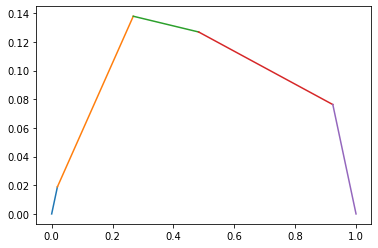

In [64]:
x = np.zeros(len(E)+1)
y = np.zeros(len(E)+1)

for i in range(len(E)-1):
    x[i+1],y[i+1] = intersection(p,E[i],p,E[i+1])
x[len(E)],y[len(E)] = (1,0)
for i in range(len(E)):
    plt.plot([x[i],x[i+1]],[y[i],y[i+1]])